In [1]:
import pynwb
import lindi
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from math import isclose
from scipy.stats import mannwhitneyu, median_abs_deviation, kstest



In [2]:
# read in the NWB file
#f = lindi.LindiH5pyFile.from_lindi_file("https://lindi.neurosift.org/dandi/dandisets/000253/assets/89fa5067-31a8-4f2d-a043-5721120501a0/nwb.lindi.json")
#nwbfile = pynwb.NWBHDF5IO(file=f, mode='r').read()

#filename = '/Users/smprince/Documents/code/Hippie/nwb_data/sub-621890_ses-1186358749_ogen.nwb' # SST
filename = '/Users/smprince/Documents/code/Hippie/nwb_data/sub-640507_ses-1217213788_ogen.nwb' # Pvalb
# filename = '/Users/smprince/Documents/code/Hippie/nwb_data/sub-774672354_ses-794812542.nwb' # original databook example
nwbfile = pynwb.NWBHDF5IO(filename, mode='r').read()

In [3]:
# load the units data and get brain areas for each unit
units = nwbfile.units
peak_channels = units.to_dataframe()['peak_channel_id']
electrodes_df = nwbfile.electrodes.to_dataframe()
brain_areas = electrodes_df.loc[peak_channels]['location'].to_numpy()
brain_areas

array(['APN', 'APN', 'APN', ..., 'MGv', 'MGv', 'MGd'],
      shape=(2378,), dtype=object)

In [4]:
# get stimulus times
stim_table = nwbfile.processing["optotagging"]["optogenetic_stimulation"]
stim_df = stim_table.to_dataframe()
stim_df.head()


,start_time,condition,level,stop_time,stimulus_name,duration,tags,timeseries
id,,,,,,,,
0,7027.32640,Each pulse is 10 ms wide,0.97,7028.32640,5 hz pulse train,1.0,[optical_stimulation],"[(0, 1, optotagging pynwb.ogen.OptogeneticSeri..."
1,7029.39041,Each pulse is 6 ms wide,1.35,7030.39041,40 hz pulse train,1.0,[optical_stimulation],"[(1, 1, optotagging pynwb.ogen.OptogeneticSeri..."
2,7031.15988,Each pulse is 10 ms wide,1.35,7032.15988,5 hz pulse train,1.0,[optical_stimulation],"[(2, 1, optotagging pynwb.ogen.OptogeneticSeri..."
3,7033.11323,Each pulse is 10 ms wide,0.97,7034.11323,5 hz pulse train,1.0,[optical_stimulation],"[(3, 1, optotagging pynwb.ogen.OptogeneticSeri..."
4,7035.21728,Each pulse is 6 ms wide,0.77,7036.21728,40 hz pulse train,1.0,[optical_stimulation],"[(4, 1, optotagging pynwb.ogen.OptogeneticSeri..."


In [62]:
# get unique stimulus conditions
stim_df.condition.unique()


array(['Each pulse is 10 ms wide', 'Each pulse is 6 ms wide',
       'half-period of a cosine wave'], dtype=object)

In [63]:
stim_duration = 0.01  # 1s of 10 ms pulses
stim_times = stim_df['start_time'][stim_df['condition'] == 'Each pulse is 10 ms wide'].to_numpy()
#stim_times = stim_df['start_time'][stim_df['condition'] == 'a single square pulse'].to_numpy() - use for example visual coding dataset

In [64]:
import pynapple as nap
data = nap.load_file(filename)


/Users/smprince/anaconda3/envs/hippie/lib/python3.10/site-packages/pynapple/io/interface_nwb.py:133: UserWarning: end is not sorted. Cannot add metadata to unsorted end times. Sorting it and dropping metadata.
  data = nap.IntervalSet(df)
/Users/smprince/anaconda3/envs/hippie/lib/python3.10/site-packages/pynapple/io/interface_nwb.py:133: UserWarning: Some ends precede the relative start. Dropping them!
  data = nap.IntervalSet(df)
/Users/smprince/anaconda3/envs/hippie/lib/python3.10/site-packages/pynapple/io/interface_nwb.py:133: UserWarning: epochs have changed, dropping metadata.
  data = nap.IntervalSet(df)


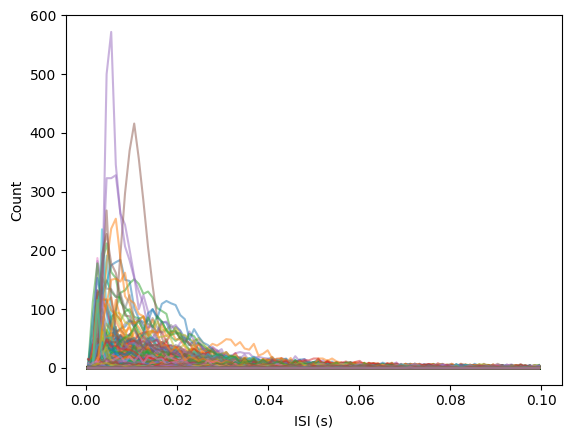

In [65]:
# compute ISI distributions within spontaneous epochs. TODO - expand to other epochs?
isi_distribution = nap.compute_isi_distribution(
    data=data['units'], bins=np.linspace(0, 0.1, 100), epochs=data['spontaneous_presentations']
    )
isi_distribution
for col in isi_distribution.columns:
    plt.plot(
        isi_distribution.index,
        isi_distribution[col].values,
        alpha=0.5,
        label=col,
    )
plt.xlabel("ISI (s)")
plt.ylabel("Count")
plt.show()

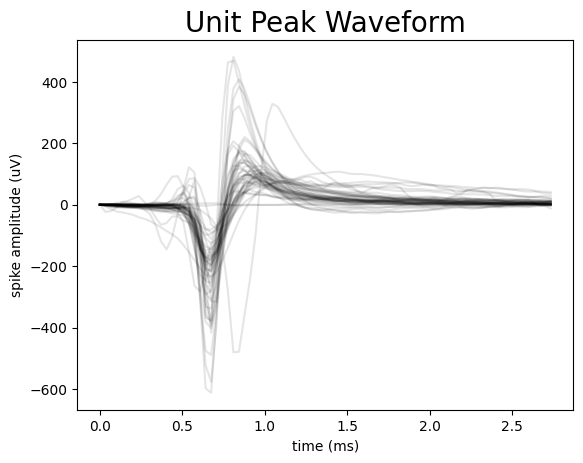

In [67]:
channel_id_to_local_index = {}
for i in range(len(nwbfile.electrodes)):
    channel_id_to_local_index[nwbfile.electrodes['id'][i]] = nwbfile.electrodes['local_index'][i]

peak_waveforms = []
for index in range(len(units)):
    unit_mean_waveform = units['waveform_mean'][index]
    units_channel_id = units['peak_channel_id'][index]
    local_index = channel_id_to_local_index[units_channel_id]
    peak_waveform = unit_mean_waveform[local_index]

    peak_waveforms.append(peak_waveform)


peak_channel_waveforms = np.array(peak_waveforms).T
# these will be the same for each unit in this experiment, so we can index the first unit to define these values
Hz = nwbfile.devices['probeB'].sampling_rate
n_secs = peak_waveform.shape[0] / Hz

fig, ax = plt.subplots()

n_secs = len(peak_channel_waveforms[:,0]) / Hz 
time_axis = np.linspace(0, n_secs * 1000, len(peak_channel_waveforms[:,0]))

ax.plot(time_axis, peak_channel_waveforms[:, :50], color='k', alpha=0.1)

ax.set_xlabel("time (ms)")
ax.set_ylabel("spike amplitude (uV)")
ax.set_title("Unit Peak Waveform", fontsize=20)

plt.show()

In [70]:
def show_counts(counts_array, bin_edges, figax=None, stim_bounds=[], title="", c_label="", vmin=None, vmax=None):
    if figax == None:
        fig, ax = plt.subplots(figsize=(6,10)) # change fig size for different plot dimensions
    else:
        fig, ax = figax

    img = ax.imshow(counts_array, 
                    extent=[np.min(bin_edges), np.max(bin_edges), 0, len(counts_array)], 
                    aspect="auto",
                    vmin=vmin,
                    vmax=vmax) # change vmax to get a better depiction of your data

    for bound in stim_bounds:
        ax.plot([bound, bound],[0, len(counts_array)], ':', color='white', linewidth=1.0)

    ax.set_xlabel("Time relative to stimulus onset (s)")
    ax.set_ylabel("Unit #")
    ax.set_title(title)

    cbar = fig.colorbar(img, shrink=0.5)
    cbar.set_label(c_label)

In [74]:
censor_period = 0.002  # period to exclude from analysis before and after the stimulus event 
time_resolution = 0.002 # 2 ms bin size for counting spikes

# start and end times (relative to the stimulus at 0 seconds) that we want to examine and align spikes to
# the baseline interval will be window_start_time to 0-censor_period
window_start_time = -0.01 # 100 ms before the stimulus
window_end_time = 0.025 # 1 second for full stimulus

# define spiking functions
def get_spike_matrix(stim_times, units_spike_times, bin_edges):
    time_resolution = np.mean(np.diff(bin_edges))
    # 3D spike matrix to be populated with spike counts
    spike_matrix = np.zeros((len(units_spike_times), len(stim_times), len(bin_edges)-1))

    # populate 3D spike matrix for each unit for each stimulus trial by counting spikes into bins
    for unit_idx in tqdm(range(len(units_spike_times))):
        spike_times = units_spike_times[unit_idx]

        for stim_idx, stim_time in enumerate(stim_times):
            # get spike times that fall within the bin's time range relative to the stim time        
            first_bin_time = stim_time + bin_edges[0]
            last_bin_time = stim_time + bin_edges[-1]
            first_spike_in_range, last_spike_in_range = np.searchsorted(spike_times, [first_bin_time, last_bin_time])
            spike_times_in_range = spike_times[first_spike_in_range:last_spike_in_range]

            # convert spike times into relative time bin indices
            bin_indices = ((spike_times_in_range - (first_bin_time)) / time_resolution).astype(int)
            
            # mark that there is a spike at these bin times for this unit on this stim trial
            for bin_idx in bin_indices:
                spike_matrix[unit_idx, stim_idx, bin_idx] += 1

    return spike_matrix

def get_spike_counts(stim_times, spike_times, censor_period, stim_duration, time_resolution, window_start_time, window_end_time):
    # time bins used
    n_bins = int((window_end_time - window_start_time) / time_resolution)
    bin_edges = np.linspace(window_start_time, window_end_time, n_bins, endpoint=True)

    # calculate baseline and stimulus interval indices for use later
    stim_start_time = censor_period
    stim_end_time = stim_duration - censor_period
    stim_start_idx = int((stim_start_time - (bin_edges[0])) / time_resolution)
    stim_end_idx = int((stim_end_time - (bin_edges[0])) / time_resolution)
    bl_start_idx = 0
    bl_end_idx = int((0-censor_period-bin_edges[0]) / time_resolution)

    spike_matrix = get_spike_matrix(stim_times, spike_times, bin_edges)

    # aggregate all stim trials to get total spikes by unit over time
    spike_counts = np.sum(spike_matrix, axis=1)

    return spike_counts, spike_matrix, bin_edges, bl_start_idx, bl_end_idx, stim_start_idx, stim_end_idx

In [75]:
spike_times = nwbfile.units['spike_times']
spike_counts, spike_matrix, bin_edges, bl_start, bl_end, stim_start, stim_end = get_spike_counts(stim_times, spike_times, censor_period, stim_duration, time_resolution, window_start_time, window_end_time)


100%|██████████| 2378/2378 [00:00<00:00, 2609.64it/s]


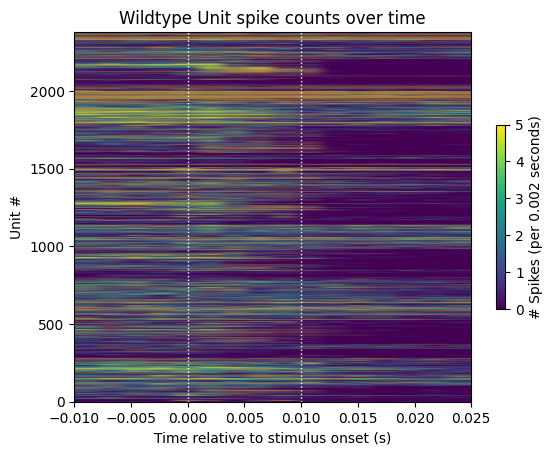

In [ ]:
fig, axes = plt.subplots(1,1)


show_counts(spike_counts,
            bin_edges,
            figax = (fig, axes),
            stim_bounds=[0, stim_duration],
            title="Wildtype Unit spike counts over time",
            c_label=f"# Spikes (per {time_resolution} seconds)",
            vmin=0,
            vmax=5)

100%|██████████| 2378/2378 [00:01<00:00, 1686.86it/s]


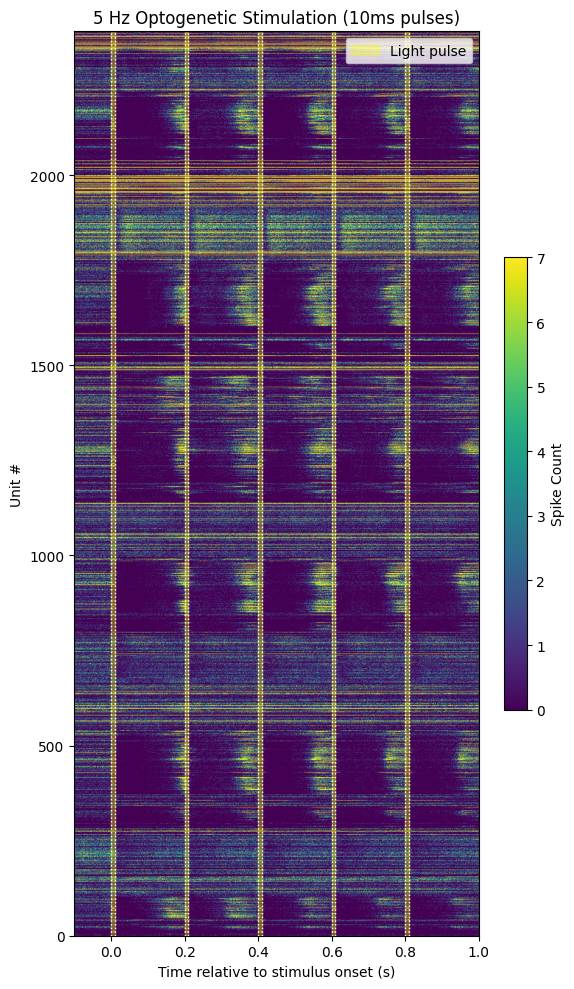

In [78]:
censor_period = 0.002  # period to exclude from analysis before and after the stimulus event 
time_resolution = 0.002 # 2 ms bin size for counting spikes

# start and end times (relative to the stimulus at 0 seconds) that we want to examine and align spikes to
window_start_time = -0.100 # 100 ms before the stimulus
window_end_time = 1.0 # 1 second after stimulus onset

# Define your 5 Hz stimulus parameters
stim_frequency = 5  # Hz
pulse_width = 0.010  # 10ms pulses
stim_duration = 1.0  # Total duration of stimulus train
inter_pulse_interval = 1.0 / stim_frequency  # 200ms between pulse onsets

# Calculate pulse times within the stimulus period
pulse_onsets = np.arange(0, stim_duration, inter_pulse_interval)
pulse_offsets = pulse_onsets + pulse_width

def get_spike_counts(stim_times, spike_times, censor_period, stim_duration, time_resolution, window_start_time, window_end_time):
    # Fix: Use endpoint=False and add one more bin
    n_bins = int((window_end_time - window_start_time) / time_resolution)
    bin_edges = np.linspace(window_start_time, window_end_time, n_bins + 1, endpoint=True)

    # calculate baseline and stimulus interval indices for use later
    stim_start_time = censor_period
    stim_end_time = stim_duration - censor_period
    stim_start_idx = int((stim_start_time - window_start_time) / time_resolution)
    stim_end_idx = int((stim_end_time - window_start_time) / time_resolution)
    bl_start_idx = 0
    bl_end_idx = int((0 - censor_period - window_start_time) / time_resolution)

    spike_matrix = get_spike_matrix(stim_times, spike_times, bin_edges)

    # aggregate all stim trials to get total spikes by unit over time
    spike_counts = np.sum(spike_matrix, axis=1)

    return spike_counts, spike_matrix, bin_edges, bl_start_idx, bl_end_idx, stim_start_idx, stim_end_idx

# Your existing function calls
spike_times = nwbfile.units['spike_times']
spike_counts, spike_matrix, bin_edges, bl_start, bl_end, stim_start, stim_end = get_spike_counts(
    stim_times, spike_times, censor_period, stim_duration, time_resolution, window_start_time, window_end_time
)

# Updated plotting function with stimulus bounds
def show_counts(counts_array, bin_edges, figax=None, stim_bounds=[], title="", c_label="", vmin=None, vmax=None):
    if figax == None:
        fig, ax = plt.subplots(figsize=(6,10))
    else:
        fig, ax = figax

    img = ax.imshow(counts_array, 
                    extent=[np.min(bin_edges), np.max(bin_edges), 0, len(counts_array)], 
                    aspect="auto",
                    vmin=vmin,
                    vmax=vmax)

    # Plot stimulus bounds (pulse onsets and offsets)
    for bound in stim_bounds:
        ax.axvline(x=bound, color='white', linestyle=':', linewidth=1.0)

    ax.set_xlabel("Time relative to stimulus onset (s)")
    ax.set_ylabel("Unit #")
    ax.set_title(title)

    cbar = fig.colorbar(img, shrink=0.5)
    cbar.set_label(c_label)
    
    return fig, ax

# Create stimulus bounds for plotting (showing pulse onsets and offsets)
stim_bounds = []
for onset, offset in zip(pulse_onsets, pulse_offsets):
    stim_bounds.extend([onset, offset])

# Plot with stimulus bounds
fig, ax = show_counts(
    spike_counts, 
    bin_edges, 
    stim_bounds=stim_bounds,
    title="5 Hz Optogenetic Stimulation (10ms pulses)",
    c_label="Spike Count",
    vmax=np.percentile(spike_counts, 95)  # Set vmax to 95th percentile for better visualization
)

# Optional: Add shaded regions for pulses instead of just lines
for onset, offset in zip(pulse_onsets, pulse_offsets):
    ax.axvspan(onset, offset, alpha=0.3, color='yellow', label='Light pulse' if onset == pulse_onsets[0] else "")

if len(pulse_onsets) > 0:
    ax.legend()

plt.tight_layout()
plt.show()

In [79]:
# calculate cell type metric
# from Westerberg et al. 2025 - Cells whose mean response during the stimulation epoch
# positively exceeded 2 standard deviations of their baseline prestimulus (100 ms epoch) activity to any of the
# stimulation types were deemed to belong to the associated interneuron group.

def calculate_optotagging_response(spike_counts, bin_edges, stim_start_idx, stim_end_idx, bl_start_idx, bl_end_idx, time_resolution):
    """
    Calculate optotagging response based on the criteria:
    Mean response during stimulation > baseline_mean + 2*baseline_std
    
    Parameters:
    -----------
    spike_counts : array, shape (n_units, n_time_bins)
        Spike counts for each unit across time bins
    bin_edges : array
        Time bin edges
    stim_start_idx, stim_end_idx : int
        Start and end indices for stimulation period
    bl_start_idx, bl_end_idx : int  
        Start and end indices for baseline period
    time_resolution : float
        Time resolution in seconds
    
    Returns:
    --------
    response_values : array, shape (n_units,)
        Response value for each unit (positive means responsive)
    baseline_rates : array, shape (n_units,)
        Baseline firing rates (Hz)
    stim_rates : array, shape (n_units,)
        Stimulation period firing rates (Hz)
    thresholds : array, shape (n_units,)
        Response threshold for each unit (baseline_mean + 2*baseline_std)
    """
    
    n_units = spike_counts.shape[0]
    
    # Calculate baseline period duration
    baseline_duration = (bl_end_idx - bl_start_idx) * time_resolution
    
    # Calculate stimulation period duration  
    stim_duration = (stim_end_idx - stim_start_idx) * time_resolution
    
    # Extract baseline and stimulation spike counts
    baseline_counts = spike_counts[:, bl_start_idx:bl_end_idx]  # shape: (n_units, n_baseline_bins)
    stim_counts = spike_counts[:, stim_start_idx:stim_end_idx]  # shape: (n_units, n_stim_bins)
    
    # Convert to firing rates (Hz)
    baseline_rates = np.sum(baseline_counts, axis=1) / baseline_duration
    stim_rates = np.sum(stim_counts, axis=1) / stim_duration
    
    # Calculate baseline statistics (mean and std of firing rate)
    baseline_mean = baseline_rates
    baseline_std = np.std(baseline_counts / time_resolution, axis=1)  # std of instantaneous rates
    
    # Calculate threshold: baseline_mean + 2*baseline_std
    thresholds = baseline_mean + 2 * baseline_std
    
    # Calculate response value: how much stim_rate exceeds threshold
    response_values = stim_rates - thresholds
    
    return response_values, baseline_rates, stim_rates, thresholds

def identify_optotagged_units(response_values):
    """
    Identify units that are optotagged based on response values
    
    Parameters:
    -----------
    response_values : array
        Response values from calculate_optotagging_response
        
    Returns:
    --------
    optotagged_mask : array of bool
        True for units that are optotagged
    optotagged_indices : array of int
        Indices of optotagged units
    """
    optotagged_mask = response_values > 0
    optotagged_indices = np.where(optotagged_mask)[0]
    
    return optotagged_mask, optotagged_indices

# Usage with your existing code:
stim_duration = 0.010  # 10ms pulse duration

# Get your spike counts (assuming you already have this)
spike_counts, spike_matrix, bin_edges, bl_start, bl_end, stim_start, stim_end = get_spike_counts(
    stim_times, spike_times, censor_period, stim_duration, time_resolution, window_start_time, window_end_time
)

# Calculate optotagging responses
response_values, baseline_rates, stim_rates, thresholds = calculate_optotagging_response(
    spike_counts, bin_edges, stim_start, stim_end, bl_start, bl_end, time_resolution
)

# Identify optotagged units
optotagged_mask, optotagged_indices = identify_optotagged_units(response_values)

# Print results
print(f"Found {len(optotagged_indices)} optotagged units out of {len(response_values)} total units")
print(f"Optotagged unit indices: {optotagged_indices}")

# Print detailed results for each unit
for i, (resp_val, bl_rate, stim_rate, thresh) in enumerate(zip(response_values, baseline_rates, stim_rates, thresholds)):
    status = "OPTOTAGGED" if resp_val > 0 else "not responsive"
    print(f"Unit {i}: {status} | Baseline: {bl_rate:.2f} Hz | Stim: {stim_rate:.2f} Hz | Threshold: {thresh:.2f} Hz | Response: {resp_val:.2f}")



100%|██████████| 2378/2378 [00:01<00:00, 1783.64it/s]


Found 176 optotagged units out of 2378 total units
Optotagged unit indices: [  85  125  131  132  135  142  144  152  154  160  182  183  184  189
  194  209  222  225  229  230  233  234  235  239  241  242  243  244
  245  248  249  250  251  253  256  257  258  262  268  275  288  299
  305  528  637  639  646  657  660  662  666  671  686  701  703  709
  712  715  721  727  731  733  736  741  742  743  747  750  751  758
  759  765  772  773  789  819  903  926  937  951  955  987  996 1013
 1039 1048 1054 1064 1070 1080 1114 1117 1123 1125 1126 1128 1129 1136
 1137 1141 1142 1144 1149 1154 1167 1174 1175 1186 1267 1278 1305 1335
 1364 1389 1397 1398 1415 1442 1454 1455 1467 1472 1495 1498 1505 1512
 1513 1518 1519 1532 1533 1534 1536 1636 1658 1761 1796 1800 1848 1859
 1861 1869 1875 1891 1895 1910 1915 1921 1923 1931 1932 1941 1947 1961
 1962 1973 1977 1980 1981 1984 1986 1991 2118 2198 2281 2283 2284 2302
 2305 2306 2310 2318 2319 2365 2366 2368]
Unit 0: not responsive | Basel


Creating plots for 176 optotagged units...


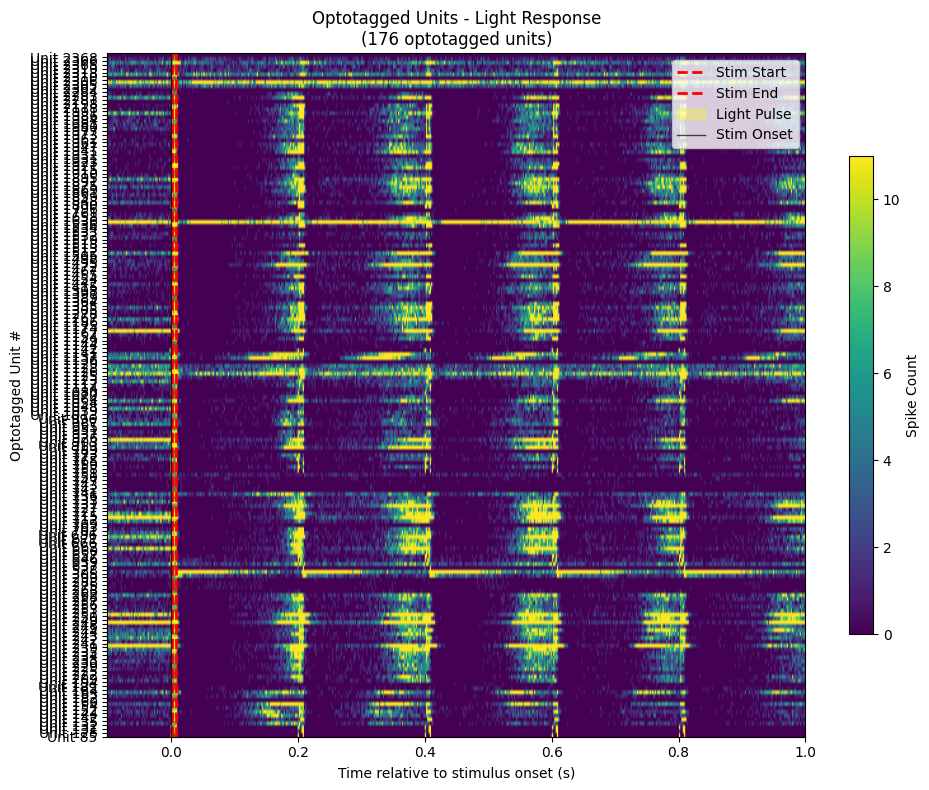

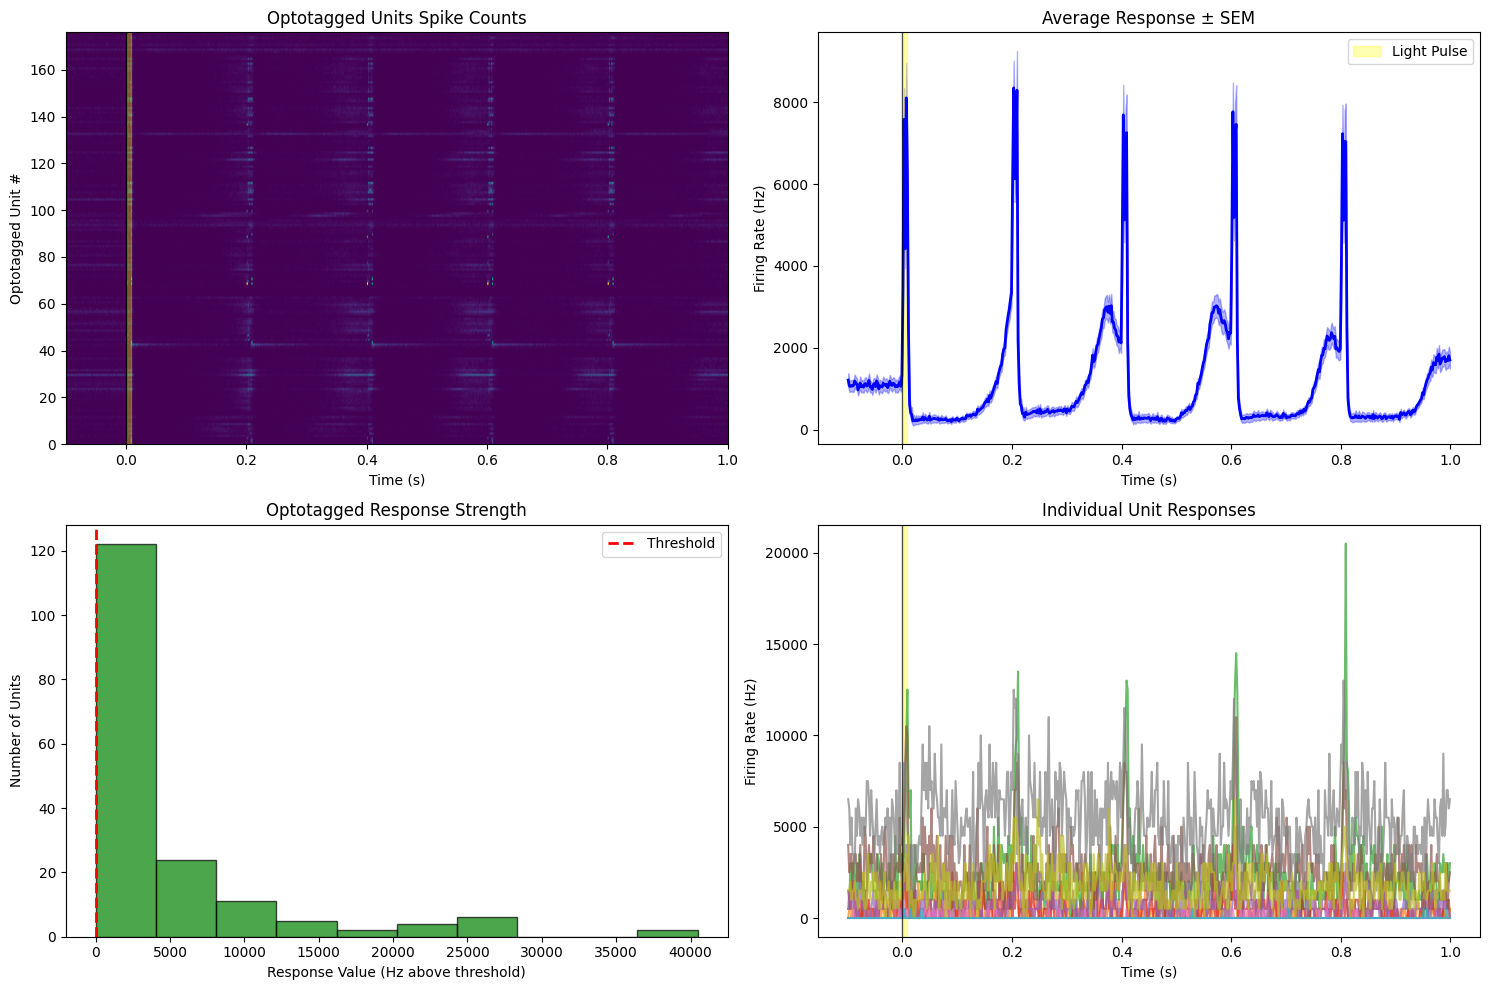

In [81]:
def plot_optotagged_units(spike_counts, bin_edges, optotagged_indices, stim_start_idx, stim_end_idx, 
                         title="Optotagged Units Response", figsize=(10, 8)):
    """
    Plot spike counts for optotagged units only
    
    Parameters:
    -----------
    spike_counts : array, shape (n_units, n_time_bins)
        Spike counts for all units
    bin_edges : array
        Time bin edges
    optotagged_indices : array
        Indices of optotagged units
    stim_start_idx, stim_end_idx : int
        Start and end indices for stimulation period
    title : str
        Plot title
    figsize : tuple
        Figure size
    """
    
    if len(optotagged_indices) == 0:
        print("No optotagged units found!")
        return None, None
    
    # Extract spike counts for optotagged units only
    optotagged_spike_counts = spike_counts[optotagged_indices, :]
    
    # Create the plot
    fig, ax = plt.subplots(figsize=figsize)
    
    # Create the heatmap
    img = ax.imshow(optotagged_spike_counts, 
                    extent=[bin_edges[0], bin_edges[-1], 0, len(optotagged_indices)], 
                    aspect="auto",
                    cmap='viridis',
                    vmin=0,
                    vmax=np.percentile(optotagged_spike_counts, 95))
    
    # Add stimulus period boundaries
    stim_start_time = bin_edges[stim_start_idx]
    stim_end_time = bin_edges[stim_end_idx]
    
    ax.axvline(x=stim_start_time, color='red', linestyle='--', linewidth=2, label='Stim Start')
    ax.axvline(x=stim_end_time, color='red', linestyle='--', linewidth=2, label='Stim End')
    
    # Highlight stimulus period
    ax.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='yellow', label='Light Pulse')
    
    # Add baseline period indicator
    ax.axvline(x=0, color='black', linestyle='-', linewidth=1, alpha=0.7, label='Stim Onset')
    
    # Labels and formatting
    ax.set_xlabel("Time relative to stimulus onset (s)")
    ax.set_ylabel("Optotagged Unit #")
    ax.set_title(f"{title}\n({len(optotagged_indices)} optotagged units)")
    
    # Add colorbar
    cbar = fig.colorbar(img, shrink=0.7)
    cbar.set_label("Spike Count")
    
    # Add legend
    ax.legend(loc='upper right')
    
    # Set y-tick labels to show actual unit indices
    y_ticks = np.arange(len(optotagged_indices))
    y_labels = [f"Unit {idx}" for idx in optotagged_indices]
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_labels)
    
    plt.tight_layout()
    
    return fig, ax

def plot_optotagged_summary(spike_counts, bin_edges, optotagged_indices, response_values, 
                           stim_start_idx, stim_end_idx, time_resolution):
    """
    Create a comprehensive summary plot for optotagged units
    """
    
    if len(optotagged_indices) == 0:
        print("No optotagged units found!")
        return None, None
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot 1: Heatmap of optotagged units
    ax1 = axes[0, 0]
    optotagged_spike_counts = spike_counts[optotagged_indices, :]
    
    img1 = ax1.imshow(optotagged_spike_counts, 
                      extent=[bin_edges[0], bin_edges[-1], 0, len(optotagged_indices)], 
                      aspect="auto",
                      cmap='viridis')
    
    stim_start_time = bin_edges[stim_start_idx]
    stim_end_time = bin_edges[stim_end_idx]
    ax1.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='yellow')
    ax1.axvline(x=0, color='black', linestyle='-', linewidth=1)
    
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Optotagged Unit #")
    ax1.set_title("Optotagged Units Spike Counts")
    
    # Plot 2: Average response of optotagged units
    ax2 = axes[0, 1]
    mean_response = np.mean(optotagged_spike_counts, axis=0)
    sem_response = np.std(optotagged_spike_counts, axis=0) / np.sqrt(len(optotagged_indices))
    
    # Convert to firing rate (Hz)
    time_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    firing_rate = mean_response / time_resolution
    firing_rate_sem = sem_response / time_resolution
    
    ax2.plot(time_centers, firing_rate, 'b-', linewidth=2)
    ax2.fill_between(time_centers, firing_rate - firing_rate_sem, 
                     firing_rate + firing_rate_sem, alpha=0.3, color='blue')
    
    ax2.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='yellow', label='Light Pulse')
    ax2.axvline(x=0, color='black', linestyle='-', linewidth=1, alpha=0.7)
    
    ax2.set_xlabel("Time (s)")
    ax2.set_ylabel("Firing Rate (Hz)")
    ax2.set_title("Average Response ± SEM")
    ax2.legend()
    
    # Plot 3: Response strength distribution
    ax3 = axes[1, 0]
    optotagged_response_values = response_values[optotagged_indices]
    
    ax3.hist(optotagged_response_values, bins=10, alpha=0.7, color='green', edgecolor='black')
    ax3.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Threshold')
    ax3.set_xlabel("Response Value (Hz above threshold)")
    ax3.set_ylabel("Number of Units")
    ax3.set_title("Optotagged Response Strength")
    ax3.legend()
    
    # Plot 4: Individual unit responses
    ax4 = axes[1, 1]
    
    for i, unit_idx in enumerate(optotagged_indices[:min(10, len(optotagged_indices))]):  # Show up to 10 units
        unit_firing_rate = spike_counts[unit_idx, :] / time_resolution
        ax4.plot(time_centers, unit_firing_rate, alpha=0.7, label=f'Unit {unit_idx}')
    
    ax4.axvspan(stim_start_time, stim_end_time, alpha=0.3, color='yellow')
    ax4.axvline(x=0, color='black', linestyle='-', linewidth=1, alpha=0.7)
    
    ax4.set_xlabel("Time (s)")
    ax4.set_ylabel("Firing Rate (Hz)")
    ax4.set_title("Individual Unit Responses")
    if len(optotagged_indices) <= 10:
        ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    
    return fig, axes

# Create the plots
print(f"\nCreating plots for {len(optotagged_indices)} optotagged units...")

# Simple heatmap plot
fig1, ax1 = plot_optotagged_units(spike_counts, bin_edges, optotagged_indices, 
                                  stim_start, stim_end, 
                                  title="Optotagged Units - Light Response")

# Comprehensive summary plot
fig2, axes2 = plot_optotagged_summary(spike_counts, bin_edges, optotagged_indices, 
                                      response_values, stim_start, stim_end, time_resolution)

plt.show()

# Optional: Save the plots
# fig1.savefig('optotagged_units_heatmap.png', dpi=300, bbox_inches='tight')
# fig2.savefig('optotagged_units_summary.png', dpi=300, bbox_inches='tight')